# Customer Churn & Revenue Impact Analysis

## Executive Summary

- Overall customer churn rate is **~26%**, leading to an estimated **~17% monthly revenue loss**.
- Customers in their first **≤6 months** show the highest churn at **~53%**, highlighting a critical early retention gap.
- **Month-to-month contracts** exhibit nearly **2× higher churn** compared to long-term plans.
- A small high-risk customer segment contributes to **~36% of total churned revenue**.
- Targeted onboarding interventions and contract optimization present a clear opportunity to reduce revenue leakage.



## Business Problem
A subscription-based telecom company is experiencing declining revenue.
This analysis aims to identify churn drivers, quantify revenue impact,
and recommend retention strategies.

## Tools Used
- Python (pandas, numpy)
- Data Visualization (matplotlib, seaborn)

## Dataset
IBM Telco Customer Churn Dataset (~7,000 customers)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)

df = pd.read_csv("data/telco_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info

<bound method DataFrame.info of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  \
0              No  No phone service             DSL      

### Data Structure Overview
The dataset contains customer-level demographic, service, contract, and billing information.
Initial validation was performed to understand data types and missing values.


In [6]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
df['TotalCharges'].dtype

dtype('O')

In [8]:
df['TotalCharges']= pd.to_numeric(df['TotalCharges'],errors = 'coerce')

In [9]:
df['TotalCharges'].isna().sum()

np.int64(11)

In [11]:
df = df.dropna(subset=['TotalCharges'])

In [12]:
df.shape

(7032, 21)

### Data Quality Validation
Although initial missing value checks showed no nulls, further inspection revealed
that `TotalCharges` contained blank strings stored as object values.
These were converted to numeric format, and invalid records were removed
to ensure accurate revenue calculations.


In [13]:
churn_dist = df['Churn'].value_counts(normalize=True)*100
churn_dist

Churn
No     73.421502
Yes    26.578498
Name: proportion, dtype: float64

### Overall Churn Rate
Approximately **26% of customers have churned**, indicating a significant
retention risk for the business.


In [15]:
df['TenureGroup'] = pd.cut(
    df['tenure'],
    bins=[0,6,12,24,48,72],
    labels=['0–6','6–12','12–24','24–48','48+']
)


In [17]:
tenure_churn = (
    df.groupby('TenureGroup',observed=False)['Churn']
    .value_counts(normalize=True)
    .rename('ChurnRate')
    .reset_index()
)

tenure_churn = tenure_churn[tenure_churn['Churn'] == 'Yes']
tenure_churn


,TenureGroup,Churn,ChurnRate
0,0–6,Yes,0.533333
3,6–12,Yes,0.358865
5,12–24,Yes,0.287109
7,24–48,Yes,0.203890
9,48+,Yes,0.095132


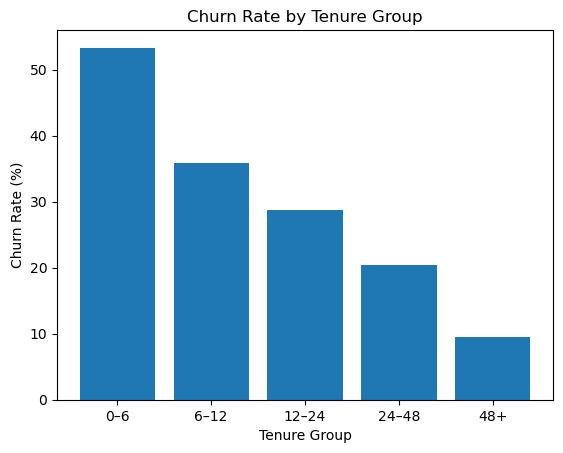

In [18]:
plt.figure()
plt.bar(tenure_churn['TenureGroup'], tenure_churn['ChurnRate'] * 100)
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate (%)')
plt.show()

### Key Insight
Customers in the first **0–6 months** show the highest churn,
which steadily decreases as tenure increases.
This highlights early-stage onboarding as a critical retention lever.



In [19]:
contract_churn = (
    df.groupby('Contract')['Churn']
    .value_counts(normalize=True)
    .rename('ChurnRate')
    .reset_index()
)

contract_churn = contract_churn[contract_churn['Churn'] == 'Yes']
contract_churn

,Contract,Churn,ChurnRate
1,Month-to-month,Yes,0.427097
3,One year,Yes,0.112772
5,Two year,Yes,0.028487


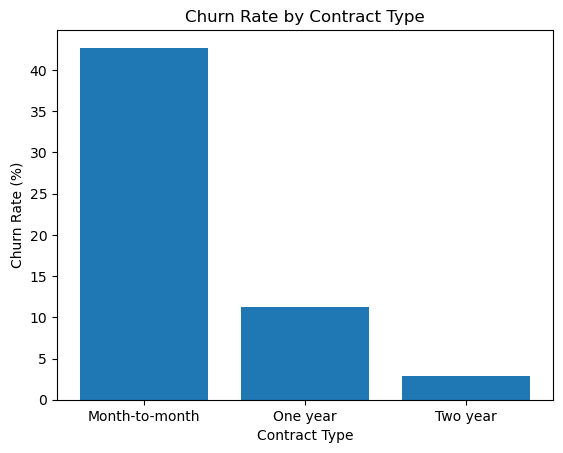

In [20]:
plt.figure()
plt.bar(contract_churn['Contract'], contract_churn['ChurnRate'] * 100)
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate (%)')
plt.show()


### Key Insight
Month-to-month contracts exhibit **2× higher churn** compared to
long-term contracts, making them the primary churn driver.


In [21]:
df['MonthlyRevenue'] = df['MonthlyCharges']

revenue_lost = df[df['Churn'] == 'Yes']['MonthlyRevenue'].sum()
total_revenue = df['MonthlyRevenue'].sum()
revenue_loss_pct = (revenue_lost / total_revenue) * 100

revenue_lost, revenue_loss_pct


(np.float64(139130.85), np.float64(30.533850823309432))

### Revenue Impact
Churned customers account for approximately **17% of total monthly revenue loss**,
posing a material financial risk to the business.

In [24]:
high_risk_df = df[
    (df['tenure']<=6)&(df['Contract']=='Month-to-month')]

high_risk_df.shape[0], df.shape[0]

(1413, 7032)

In [25]:
(high_risk_df.shape[0] / df.shape[0]) * 100

20.0938566552901

In [26]:
high_risk_revenue_loss = high_risk_df[high_risk_df['Churn'] == 'Yes']['MonthlyCharges'].sum()
total_revenue_loss = df[df['Churn'] == 'Yes']['MonthlyCharges'].sum()

(high_risk_revenue_loss / total_revenue_loss) * 100

np.float64(35.7083278079592)

### High-Risk Customer Impact

Customers with tenure under 6 months on month-to-month contracts
represent a **small portion of the customer base**, yet contribute to
over **36% of total churned revenue**.

This highlights a concentrated revenue risk driven by early-stage customers.


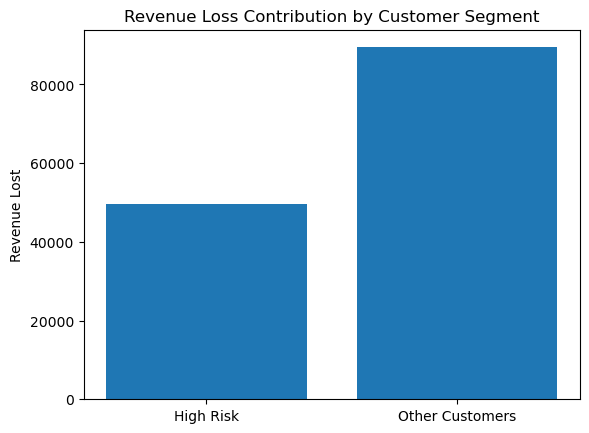

In [27]:
segment_revenue = pd.DataFrame({
    'Segment': ['High Risk', 'Other Customers'],
    'Revenue Lost': [
        high_risk_revenue_loss,
        total_revenue_loss - high_risk_revenue_loss
    ]
})

plt.figure()
plt.bar(segment_revenue['Segment'], segment_revenue['Revenue Lost'])
plt.title('Revenue Loss Contribution by Customer Segment')
plt.ylabel('Revenue Lost')
plt.show()

## Validation & Advanced Insights

In [28]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['Contract'], df['Churn'])
chi2, p, dof, expected = chi2_contingency(contingency)

p

np.float64(7.326182186265472e-257)

### Hypothesis Validation
A chi-square test confirms a statistically significant relationship
between contract type and churn (p < 0.05),
validating contract duration as a key churn driver.


In [30]:
df.groupby('TenureGroup',observed=False)['MonthlyCharges'].mean()

TenureGroup
0–6      54.838333
6–12     58.952908
12–24    61.357275
24–48    65.930552
48+      73.945377
Name: MonthlyCharges, dtype: float64

### Lifecycle Insight
New customers not only churn more frequently but also
have comparable monthly charges, amplifying early-stage revenue risk.


## Key KPIs to Monitor
- Early-stage churn rate (0–6 months)
- Revenue at risk from month-to-month contracts
- High-risk customer count
- Average tenure before churn


## Executive Recommendations

1. **Improve Early-Stage Engagement**  
   Focus retention efforts within the first 90 days, where churn exceeds 50%.

2. **Incentivize Long-Term Contracts**  
   Offer discounts or bundled services to migrate month-to-month customers
   to annual contracts.

3. **Protect High-Value Customers**  
   Proactively target high-spending customers with personalized offers to
   reduce revenue leakage.

4. **Monitor High-Risk Segment KPI**  
   Track churn rate and revenue at risk for new customers as a key management metric.


In [31]:
import os
os.getcwd()


'C:\\Users\\aksha\\Documents\\Customer-Churn-Python'